# Data pre-processing & Feature selection

## Step 1. Data pre-processing

In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv('data.csv')

In [28]:
df.head()
print(df.shape)
df['PITCH_TYPE'].isna().sum()

(1286181, 56)


493

In [29]:
df = df.dropna(subset=['PITCH_TYPE'])
df.shape

(1285688, 56)

In [30]:
df.columns

Index(['PITCH_TYPE', 'PITCH_NAME', 'PLAYER_NAME', 'BATTER_ID', 'PITCHER_ID',
       'BAT_SIDE', 'THROW_SIDE', 'GAME_PK', 'GAME_YEAR', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'INNING', 'INNING_TOPBOT', 'AT_BAT_NUMBER',
       'PITCH_NUMBER', 'OUTS_WHEN_UP', 'BALLS', 'STRIKES', 'ON_1B', 'ON_2B',
       'ON_3B', 'IF_FIELDING_ALIGNMENT', 'OF_FIELDING_ALIGNMENT', 'EVENTS',
       'DESCRIPTION', 'TYPE', 'ZONE', 'PLATE_X', 'PLATE_Z', 'SZ_TOP', 'SZ_BOT',
       'BB_TYPE', 'HIT_LOCATION', 'HC_X', 'HC_Y', 'HIT_DISTANCE_SC',
       'LAUNCH_SPEED', 'LAUNCH_ANGLE', 'ESTIMATED_BA_USING_SPEEDANGLE',
       'ESTIMATED_WOBA_USING_SPEEDANGLE', 'WOBA_VALUE', 'WOBA_DENOM',
       'BABIP_VALUE', 'ISO_VALUE', 'LAUNCH_SPEED_ANGLE', 'HOME_SCORE',
       'AWAY_SCORE', 'BAT_SCORE', 'FLD_SCORE', 'POST_AWAY_SCORE',
       'POST_HOME_SCORE', 'POST_BAT_SCORE', 'POST_FLD_SCORE',
       'DELTA_HOME_WIN_EXP', 'DELTA_RUN_EXP'],
      dtype='object')

### Drop columns that are less likely influence the Pitch type received. This can certainly rely on expert inputs.

In [31]:
columns_to_drop = [
    'PLAYER_NAME', 'PITCH_NAME', 'GAME_PK', 'EVENTS', 'DESCRIPTION', 'TYPE', 
    'ZONE', 'PLATE_X', 'PLATE_Z', 'SZ_TOP', 'SZ_BOT',
    'BB_TYPE', 'HIT_LOCATION', 'HC_X', 'HC_Y', 'HIT_DISTANCE_SC', 
    'LAUNCH_SPEED', 'LAUNCH_ANGLE', 'ESTIMATED_BA_USING_SPEEDANGLE', 
    'ESTIMATED_WOBA_USING_SPEEDANGLE', 'WOBA_VALUE', 'WOBA_DENOM', 
    'BABIP_VALUE', 'ISO_VALUE', 'LAUNCH_SPEED_ANGLE', 'POST_AWAY_SCORE', 
    'POST_HOME_SCORE', 'POST_BAT_SCORE', 'POST_FLD_SCORE', 'DELTA_HOME_WIN_EXP', 
    'DELTA_RUN_EXP', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM'
]

# Drop the columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned['PITCH_TYPE'].unique()
df_cleaned.shape

(1285688, 22)

### Map all pitching types to three categories

In [32]:
# Define the pitch type mapping
pitch_mapping = {
    # Fastball types
    'FA': 'FB', 'FF': 'FB', 'FC': 'FB', 'SI': 'FB', 'PO': 'FB',
    
    # Offspeed pitches
    'CH': 'OS', 'FO': 'OS', 'FS': 'OS', 'KN': 'OS', 'EP': 'OS',
    
    # Breaking ball pitches
    'CU': 'BB', 'CS': 'BB', 'KC': 'BB', 'SL': 'BB', 
    'ST': 'BB', 'SV': 'BB', 'SC': 'BB'
}

# Assuming df['PITCH_CODE'] is the column containing pitch codes
df_cleaned['PITCH_TYPE'] = df_cleaned['PITCH_TYPE'].map(pitch_mapping)

# Display the resulting DataFrame (optional)
df_cleaned.head()


,PITCH_TYPE,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_YEAR,INNING,INNING_TOPBOT,AT_BAT_NUMBER,PITCH_NUMBER,...,STRIKES,ON_1B,ON_2B,ON_3B,IF_FIELDING_ALIGNMENT,OF_FIELDING_ALIGNMENT,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE
0,FB,605141,608566,R,R,2021,1,Top,1,1,...,0,NaN,NaN,NaN,Standard,Standard,0,0,0,0
1,FB,605141,608566,R,R,2021,1,Top,1,2,...,0,NaN,NaN,NaN,Standard,Standard,0,0,0,0
2,FB,605141,608566,R,R,2021,1,Top,1,3,...,1,NaN,NaN,NaN,Strategic,Standard,0,0,0,0
3,FB,605141,608566,R,R,2021,1,Top,1,4,...,1,NaN,NaN,NaN,Strategic,Standard,0,0,0,0
4,FB,605141,608566,R,R,2021,1,Top,1,5,...,1,NaN,NaN,NaN,Standard,Standard,0,0,0,0


### Majority of the pitches is Fastball in the dataset

In [33]:
df_cleaned['PITCH_TYPE'].value_counts()

PITCH_TYPE
FB    719658
BB    394628
OS    171402
Name: count, dtype: int64

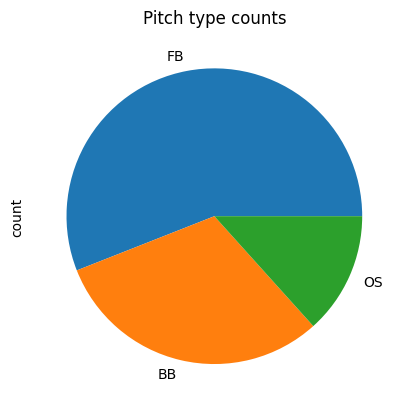

In [34]:
pt_df = df_cleaned['PITCH_TYPE'].value_counts()
pt_df.plot(kind='pie', title='Pitch type counts');

### Handle missing data

#### For ON_1B, ON_2B, ON_3B, replacing NaN with 0 indicating nobody is on 1B, etc. while other with 1 indicating someone is on the base. 

#### For IF_FIELDING_ALIGNMENT and OF_FIELDING_ALIGNMENT, fill the NaN with the most frequently appeared value which is 'Standard'

In [35]:
# Replace NaN with 0 and anything else with 1 for multiple columns
df_cleaned[['ON_1B', 'ON_2B', 'ON_3B']] = df_cleaned[['ON_1B', 'ON_2B', 'ON_3B']].applymap(lambda x: 0 if pd.isna(x) else 1)

# Display the resulting DataFrame (optional)
#print(df.head())
df_cleaned.info()

/var/folders/1s/2gfv98317bnc5_7xb_2604sc0000gp/T/ipykernel_31296/459498890.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned[['ON_1B', 'ON_2B', 'ON_3B']] = df_cleaned[['ON_1B', 'ON_2B', 'ON_3B']].applymap(lambda x: 0 if pd.isna(x) else 1)


<class 'pandas.core.frame.DataFrame'>
Index: 1285688 entries, 0 to 1286180
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   PITCH_TYPE             1285688 non-null  object
 1   BATTER_ID              1285688 non-null  int64 
 2   PITCHER_ID             1285688 non-null  int64 
 3   BAT_SIDE               1285688 non-null  object
 4   THROW_SIDE             1285688 non-null  object
 5   GAME_YEAR              1285688 non-null  int64 
 6   INNING                 1285688 non-null  int64 
 7   INNING_TOPBOT          1285688 non-null  object
 8   AT_BAT_NUMBER          1285688 non-null  int64 
 9   PITCH_NUMBER           1285688 non-null  int64 
 10  OUTS_WHEN_UP           1285688 non-null  int64 
 11  BALLS                  1285688 non-null  int64 
 12  STRIKES                1285688 non-null  int64 
 13  ON_1B                  1285688 non-null  int64 
 14  ON_2B                  1285688 non-null

In [36]:
df_cleaned['IF_FIELDING_ALIGNMENT'].value_counts()

IF_FIELDING_ALIGNMENT
Standard         782262
Infield shift    273034
Infield shade    149284
Strategic         75728
Name: count, dtype: int64

In [37]:
df_cleaned['OF_FIELDING_ALIGNMENT'].value_counts()

OF_FIELDING_ALIGNMENT
Standard          1212498
Strategic           65591
4th outfielder       2219
Name: count, dtype: int64

In [38]:
df_cleaned = df_cleaned.fillna({'IF_FIELDING_ALIGNMENT': 'Standard', 'OF_FIELDING_ALIGNMENT': 'Standard'})

#### Encode/map unique values of a categorical or object-type column to a unique integer

In [39]:
# Extract only the object-type columns
object_columns = df_cleaned.select_dtypes(include='object')

# Display the extracted columns
print(object_columns.columns)
col_list = list(object_columns.columns)
col_list

Index(['PITCH_TYPE', 'BAT_SIDE', 'THROW_SIDE', 'INNING_TOPBOT',
       'IF_FIELDING_ALIGNMENT', 'OF_FIELDING_ALIGNMENT'],
      dtype='object')


['PITCH_TYPE',
 'BAT_SIDE',
 'THROW_SIDE',
 'INNING_TOPBOT',
 'IF_FIELDING_ALIGNMENT',
 'OF_FIELDING_ALIGNMENT']

In [40]:
for c in col_list:
    df_cleaned[c+'_enc'] = pd.factorize(df_cleaned[c])[0]

df_cleaned=df_cleaned.drop(columns=col_list)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285688 entries, 0 to 1286180
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype
---  ------                     --------------    -----
 0   BATTER_ID                  1285688 non-null  int64
 1   PITCHER_ID                 1285688 non-null  int64
 2   GAME_YEAR                  1285688 non-null  int64
 3   INNING                     1285688 non-null  int64
 4   AT_BAT_NUMBER              1285688 non-null  int64
 5   PITCH_NUMBER               1285688 non-null  int64
 6   OUTS_WHEN_UP               1285688 non-null  int64
 7   BALLS                      1285688 non-null  int64
 8   STRIKES                    1285688 non-null  int64
 9   ON_1B                      1285688 non-null  int64
 10  ON_2B                      1285688 non-null  int64
 11  ON_3B                      1285688 non-null  int64
 12  HOME_SCORE                 1285688 non-null  int64
 13  AWAY_SCORE                 1285688 non-null  in

## Step 2. Feature Selection
## There are many different techiniques for feature selection. Below two approaches are shown.

### Approach 1: check the correlation of each inputs to the target

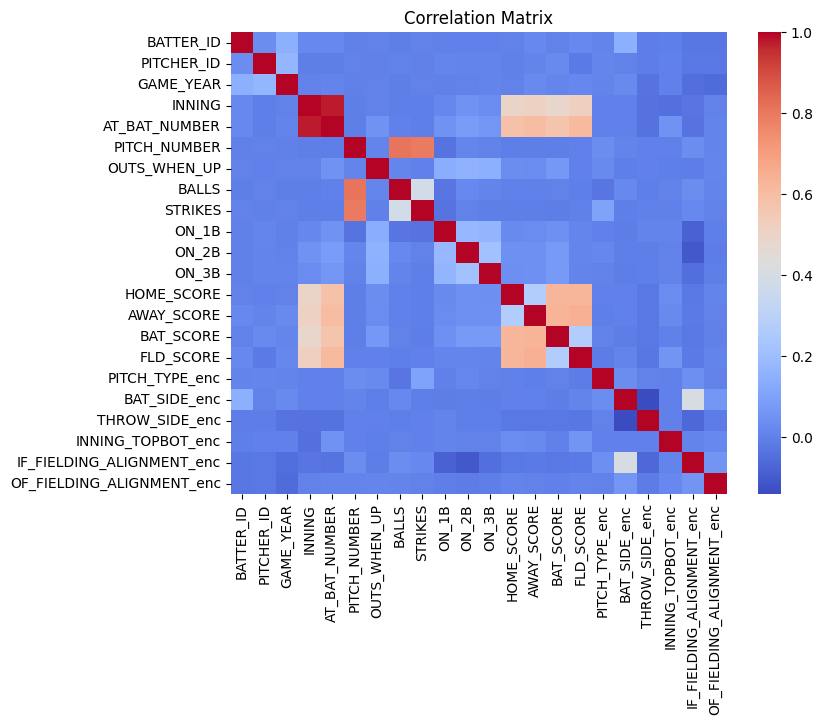

In [42]:
# Step 1: Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Step 2: Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)

# Show the plot
plt.title("Correlation Matrix")
plt.show()


Text(0.5, 1.0, 'Feature correlation to PITCH_TYPE')

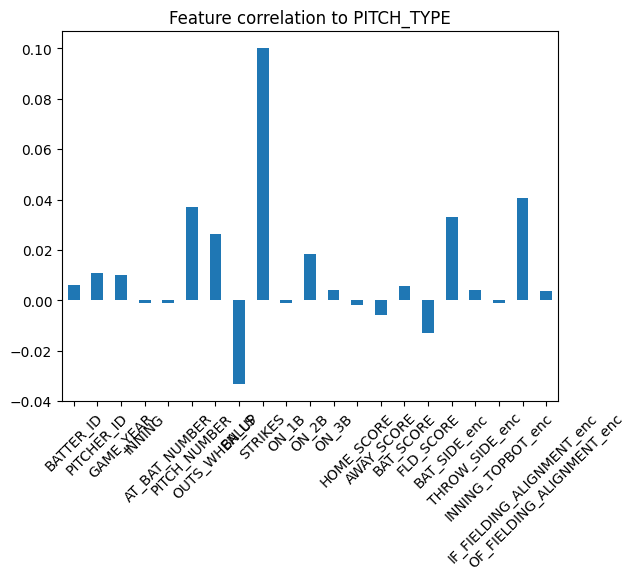

In [43]:
df_cleaned.corr().loc['PITCH_TYPE_enc'][[x for x in df_cleaned.columns if 'PITCH_TYPE_enc' not in x]].plot(kind='bar', rot=45);
plt.title('Feature correlation to PITCH_TYPE')

In [44]:
corr_pitch = df_cleaned.corr().loc['PITCH_TYPE_enc']
corr_pitch

BATTER_ID                    0.006238
PITCHER_ID                   0.010720
GAME_YEAR                    0.010165
INNING                      -0.000898
AT_BAT_NUMBER               -0.001145
PITCH_NUMBER                 0.037062
OUTS_WHEN_UP                 0.026176
BALLS                       -0.033333
STRIKES                      0.100032
ON_1B                       -0.000927
ON_2B                        0.018271
ON_3B                        0.004195
HOME_SCORE                  -0.001728
AWAY_SCORE                  -0.005895
BAT_SCORE                    0.005597
FLD_SCORE                   -0.013146
PITCH_TYPE_enc               1.000000
BAT_SIDE_enc                 0.033048
THROW_SIDE_enc               0.004216
INNING_TOPBOT_enc           -0.000873
IF_FIELDING_ALIGNMENT_enc    0.040708
OF_FIELDING_ALIGNMENT_enc    0.003826
Name: PITCH_TYPE_enc, dtype: float64

#### One way to select features are to set a threshold of correlation

In [45]:
pos_feature=corr_pitch[corr_pitch >0.01].index
pos_feature

Index(['PITCHER_ID', 'GAME_YEAR', 'PITCH_NUMBER', 'OUTS_WHEN_UP', 'STRIKES',
       'ON_2B', 'PITCH_TYPE_enc', 'BAT_SIDE_enc', 'IF_FIELDING_ALIGNMENT_enc'],
      dtype='object')

In [46]:
neg_feature = corr_pitch[corr_pitch < -0.01].index
neg_feature

Index(['BALLS', 'FLD_SCORE'], dtype='object')

In [47]:
sel_feature = list(pos_feature)+list(neg_feature)
# remove the target
sel_feature = [x for x in sel_feature if 'PITCH_TYPE_enc' not in x]
sel_feature

['PITCHER_ID',
 'GAME_YEAR',
 'PITCH_NUMBER',
 'OUTS_WHEN_UP',
 'STRIKES',
 'ON_2B',
 'BAT_SIDE_enc',
 'IF_FIELDING_ALIGNMENT_enc',
 'BALLS',
 'FLD_SCORE']

### Approach 2: Using Sklearn library feature selection models

In [48]:

# Split the data into features (X) and target (y)
X = df_cleaned.drop('PITCH_TYPE_enc', axis=1)
y = df_cleaned['PITCH_TYPE_enc']


X_train, y_train = X, y

# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Use SelectFromModel to select important features
selector = SelectFromModel(rf, threshold='mean')  # Select features with importance greater than the mean

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Transform the data to contain only the selected features
X_train_selected = selector.transform(X_train)

# Print the original features
print("Original Features:\n", X.columns)

# Print the selected features
print("\nSelected Features (after SelectFromModel):\n", X.columns[selector.get_support()])


Original Features:
 Index(['BATTER_ID', 'PITCHER_ID', 'GAME_YEAR', 'INNING', 'AT_BAT_NUMBER',
       'PITCH_NUMBER', 'OUTS_WHEN_UP', 'BALLS', 'STRIKES', 'ON_1B', 'ON_2B',
       'ON_3B', 'HOME_SCORE', 'AWAY_SCORE', 'BAT_SCORE', 'FLD_SCORE',
       'BAT_SIDE_enc', 'THROW_SIDE_enc', 'INNING_TOPBOT_enc',
       'IF_FIELDING_ALIGNMENT_enc', 'OF_FIELDING_ALIGNMENT_enc'],
      dtype='object')

Selected Features (after SelectFromModel):
 Index(['AT_BAT_NUMBER', 'PITCH_NUMBER', 'BALLS', 'STRIKES', 'BAT_SIDE_enc',
       'THROW_SIDE_enc'],
      dtype='object')
